# Usage Example - Manual Definition

This notebook describes the manual definition of a single problem, a single inverse method, the execution, and the result analysis. The first step is to define the domain and source parameters. We will consider the following configuration:

* $\lambda_b = 1$ (m)
* $L_x = L_y = 4\lambda_b$
* $N_S = N_M = 25$
* $R_O = 6\lambda_b$
* $\epsilon_{rb} = 1$
* $E_0 = 1$ (V/m)

In this problem, we wil consider only perfect dielectric materials.

The DOF for this problem is: 15

Configuration name: cfg_test
Filepath = 
Number of measurements: 25
Number of sources: 25
Observation radius: 6.000e+00 [m]
Image domain size: 4.000e+00 x 4.000e+00 [m]
Background relative permittivity: 1.0
Background conductivity: 0.000e+00 [S/m]
Frequency: 2.998e+08 [Hz]
Background wavelength: 1.000e+00 [m]
Background wavenumber: 6.283e+00+0.000e+00j [1/m]
Assumption: perfect dielectrics only


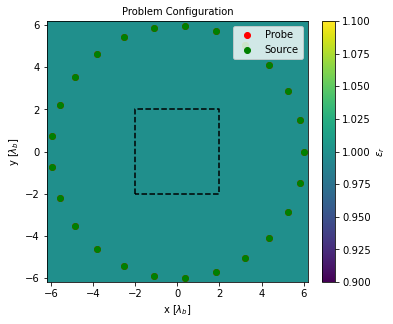

In [1]:
# Import module
import configuration as cfg

# Build configuration object
config = cfg.Configuration(name='cfg_test',
                           wavelength=1.,
                           wavelength_unit=True,
                           number_measurements=25,
                           number_sources=25,
                           image_size=[4., 4.],
                           observation_radius=6.,
                           background_permittivity=1.,
                           magnitude=1.,
                           perfect_dielectric=True)

# Computing the degrees of freedom for the equivalent problem
dof = cfg.degrees_of_freedom(1., epsilon_r=1.25, frequency=config.f)
print('The DOF for this problem is: %d\n' % dof)

# Print object info
print(config)

# Plot configuration setup
config.draw(show=True)

Next, we build the `InpudData` object, setting up the resolution on the ground-truth image, the noise level and the indicators:

* Resolution: $100\times100$ pixels
* Noise level: $1$ (%/sample)
* Indicators: $\zeta_{RN}$, $\zeta_{RPAD}$, $\zeta_{\epsilon PAD}$, $\zeta_{\epsilon OE}$, $\zeta_{\epsilon BE}$, $\zeta_P$, $\zeta_S$

In [2]:
# Load modules
import inputdata as ipt
import result as rst

# Build object
inputdata = ipt.InputData(name='ipt_test',
                          configuration=config,
                          resolution=(100, 100),
                          noise=1.,
                          indicators=[rst.RESIDUAL_PAD_ERROR,
                                      rst.RESIDUAL_NORM_ERROR,
                                      rst.REL_PERMITTIVITY_PAD_ERROR,
                                      rst.REL_PERMITTIVITY_OBJECT_ERROR,
                                      rst.REL_PERMITTIVITY_BACKGROUND_ERROR,
                                      rst.POSITION_ERROR,
                                      rst.SHAPE_ERROR,
                                      rst.EXECUTION_TIME])

# Print info
print(inputdata)

Input name: ipt_test
Configuration file: cfg_test
Images Resolution: 100x100
Noise level: 1.00%
Indicators: ['zeta_rpad', 'zeta_rn', 'zeta_epad', 'zeta_eoe', 'zeta_ebe', 'zeta_p', 'zeta_s', 'execution_time']
Degrees of Non-Linearity: None


Now, we're going to draw the scatterer image. We will consider a 5-pointed star shifted to the right-lower side of the image and rotated 25 degrees. The contrast will be set to 0.25 and the radius of the star will be set to $\lambda_b$. We will also compute its degree of non-linearity.

* $\chi = 0.25$
* $r_{max} = \lambda_b$

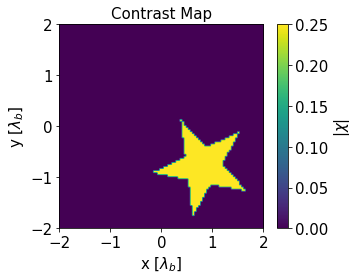

DNL is 0.2719


In [3]:
# Import module
import draw

# Set contrast
contrast = .25

# Draw figure
inputdata.rel_permittivity, _ = draw.star5(
    1., # radius
    axis_length_x=config.Lx,
    axis_length_y=config.Ly,
    resolution=inputdata.resolution,
    background_rel_permittivity=inputdata.configuration.epsilon_rb,
    object_rel_permittivity=inputdata.configuration.epsilon_rb + contrast,
    center=[-.8, .8],
    rotate=25
)

# Plot image
inputdata.draw(show=True, fontsize=15)

# Compute DNL
inputdata.compute_dnl()
print('DNL is %.4f' % inputdata.dnl)

Next step is to synthesize the scattered field data. To do this, we will use a forward solver: MoM-CG-FFT.

Execution time: 14.20 [sec]


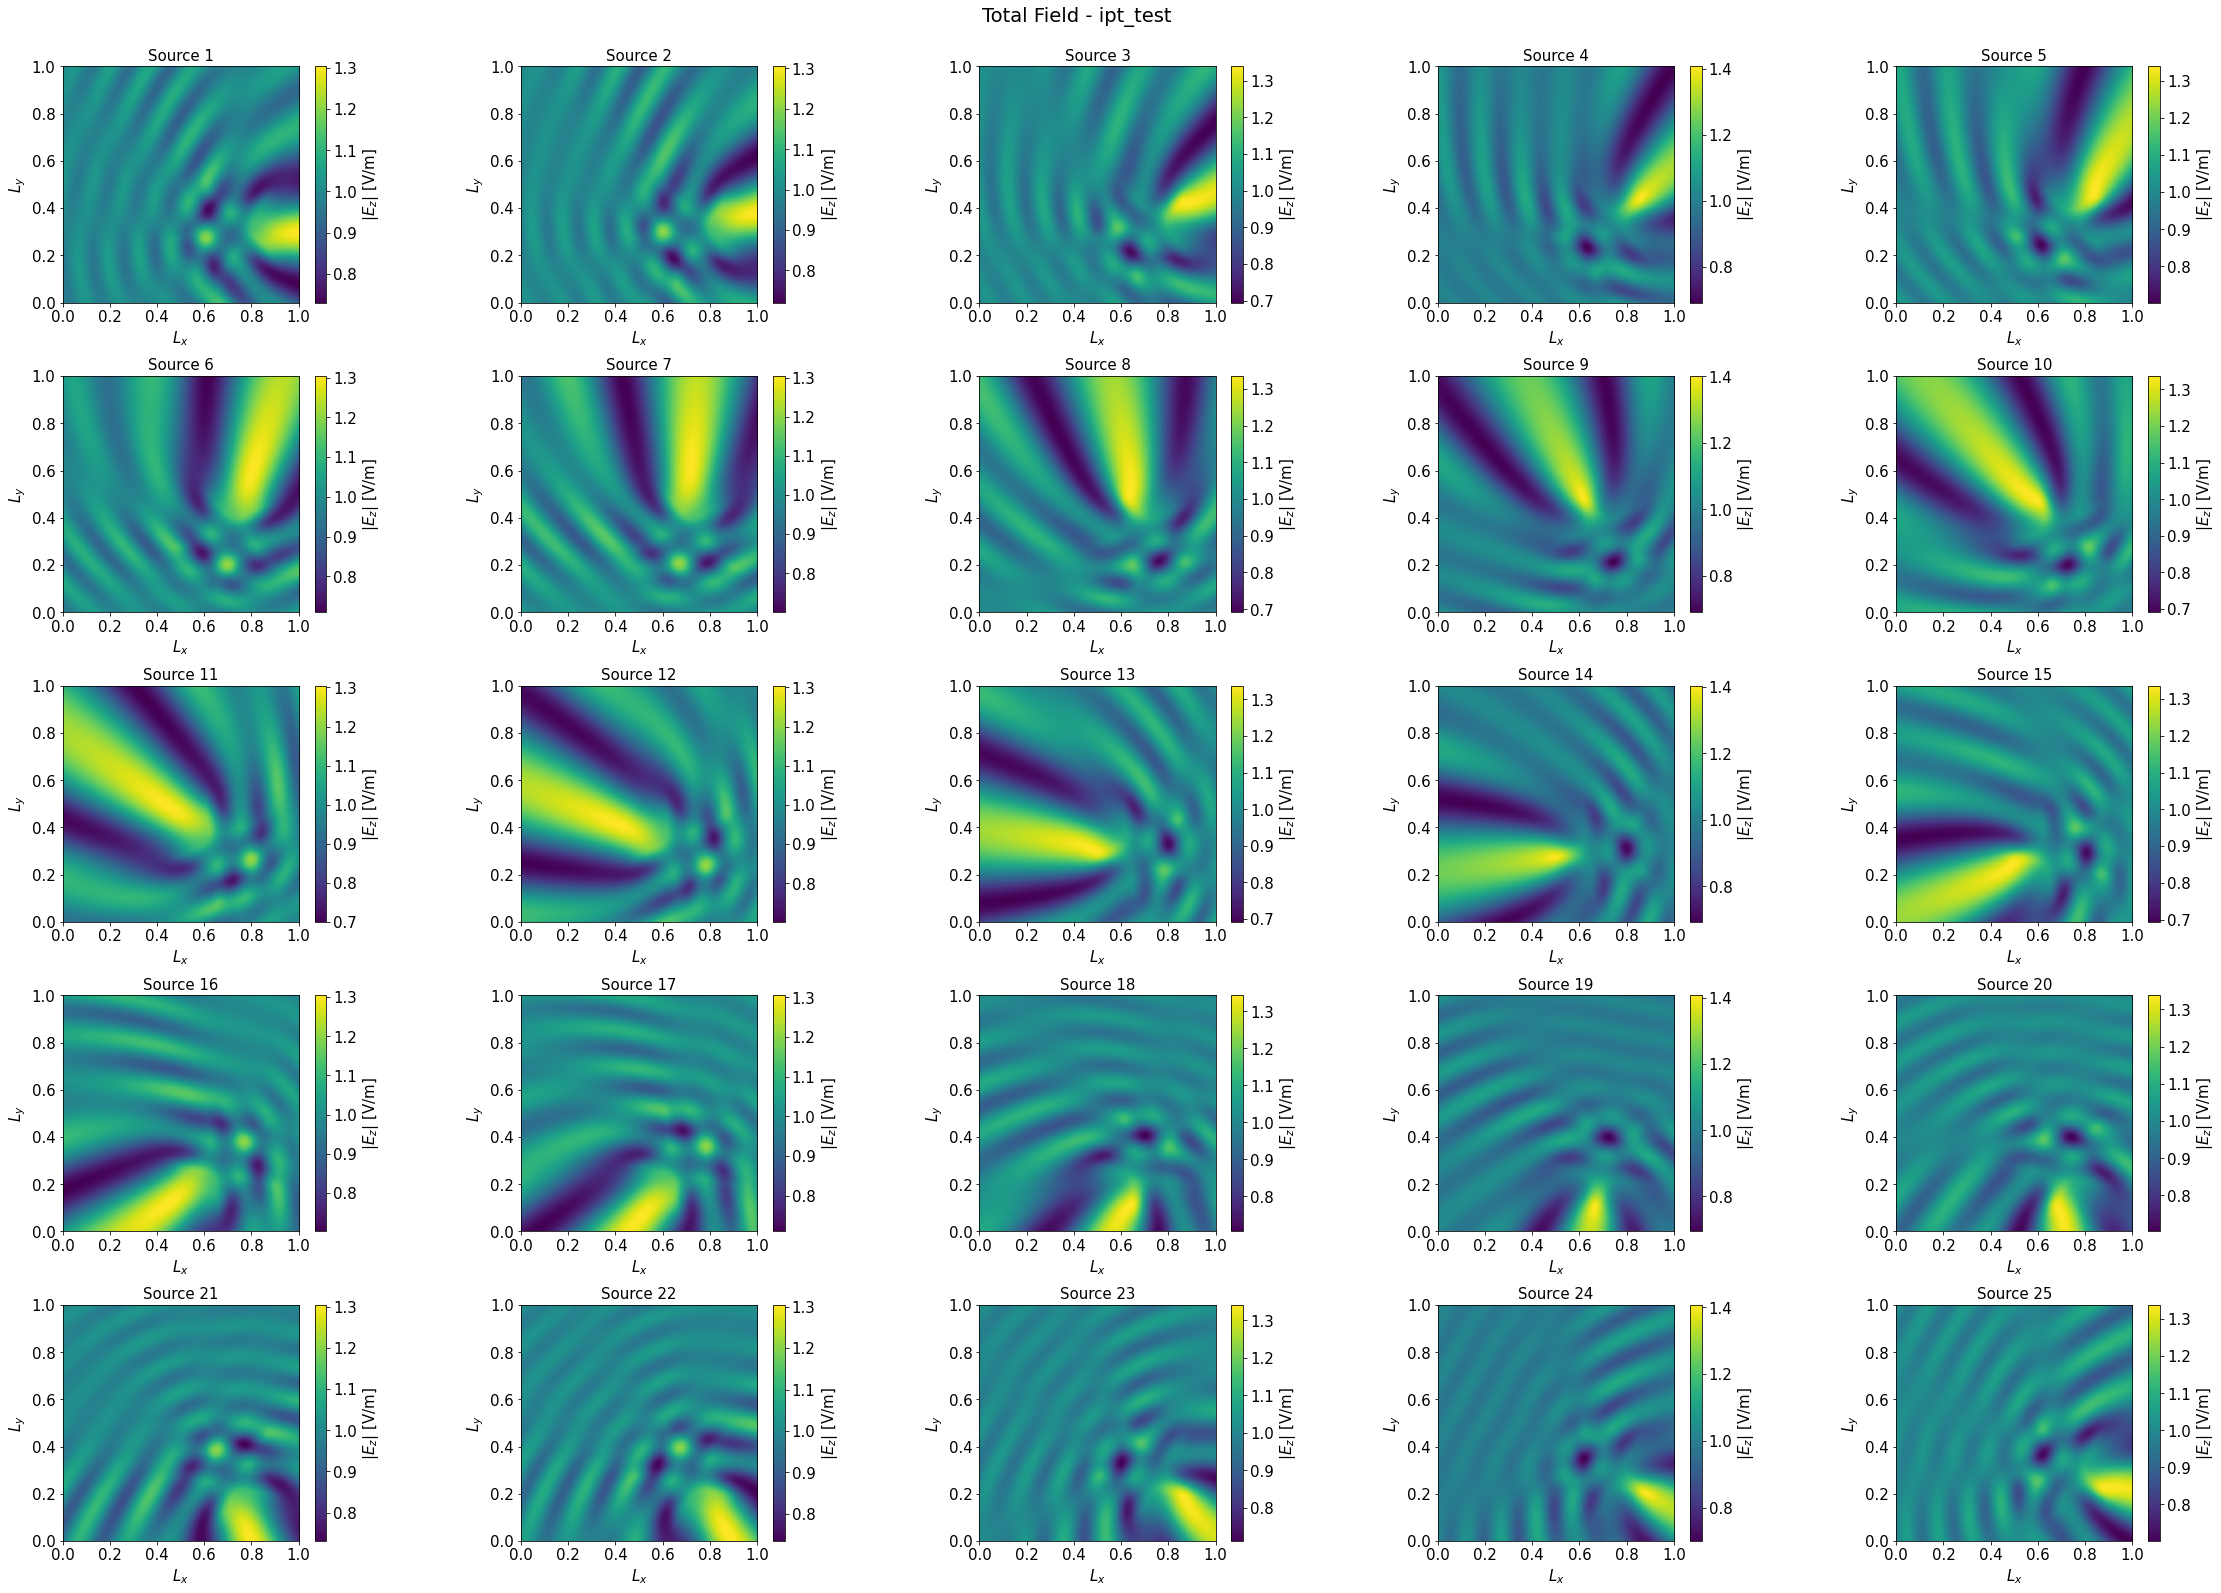

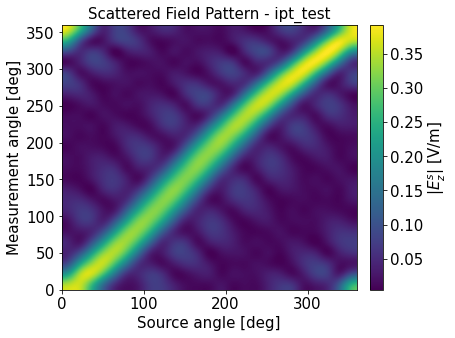

In [4]:
# Import module
import mom_cg_fft as mom

# Build forward solver object
solver = mom.MoM_CG_FFT(tolerance=.001,
                        maximum_iterations=5000)

# Solve forward problem
_ = solver.solve(inputdata,
                 PRINT_INFO=True,
                 COMPUTE_SCATTERED_FIELD=True,
                 SAVE_INTERN_FIELD=True)

# Plot total field pattern
inputdata.plot_total_field(show=True, fontsize=15)

# Plot scattered field pattern
inputdata.plot_scattered_field(show=True, fontsize=15)

Now, we will define the discretization that we will use when solving the inverse problem. We are going to use the Richmond's discretization which is the most traditional one. We will consider a lower resolution to avoid inverse crime. We will not need to compute the state equation kernel since the method we will use doesn't require it.

In [5]:
# Import module
import richmond as ric

# Number of elements (pixels)
elements = (50, 50)

# Build discretization object
discretization = ric.Richmond(config, elements, state=False)

Now, we define the method that will solve the non-linear inverse problem. We will run Born Iterative Method. Here is its configurations:

* Linear forward problem solver: MoM-CG-FFT
* Linear inverse problem solver: Tikhonov Regularization ($\alpha = 0.1$)
* Stop criterium: 5 iterations

In [6]:
# Import modules
import bim
import regularization as reg
import stopcriteria as stp

# Build object
method = bim.BornIterativeMethod(mom.MoM_CG_FFT(tolerance=0.01,
                                                maximum_iterations=2500),
                                 reg.Tikhonov(reg.TIK_FIXED, parameter=0.1),
                                 stp.StopCriteria(max_iterations=5))

Now we are able to run the algorithm:

In [7]:
result = method.solve(inputdata, discretization)

Method: Born Iterative Method
Alias: bim
Input Data: ipt_test
Discretization: Richmond Method (50x50)
Foward Solver: Method of Moments - CG-FFT
Number of iterations: 2500, Tolerance level: 1.000e-02
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e-01
Stop Criteria
Maximum number of iterations: 5
Iteration: 1 -  Residual norm: 2.625e-01, Residual PAD: 138.61%, Rel. Per. PAD: 1.19%, Rel. Per. Ob.: 7.31%, Rel. Per. Back.: 0.73%, Shape: 13.88, Position: 0.13,
Iteration: 2 -  Residual norm: 8.942e-02, Residual PAD: 46.16%, Rel. Per. PAD: 1.01%, Rel. Per. Ob.: 5.20%, Rel. Per. Back.: 0.70%, Shape: 15.30, Position: 0.17,
Iteration: 3 -  Residual norm: 7.831e-02, Residual PAD: 30.24%, Rel. Per. PAD: 0.99%, Rel. Per. Ob.: 5.01%, Rel. Per. Back.: 0.69%, Shape: 16.47, Position: 0.11,
Iteration: 4 -  Residual norm: 7.815e-02, Residual PAD: 29.22%, Rel. Per. PAD: 0.99%, Rel. Per. Ob.: 5.01%, Rel. Per. Back.: 0.68%, Shape: 16.47, Position: 0.11,
Iteration: 5 -  Residual

Let's have a look first at the recovered image:

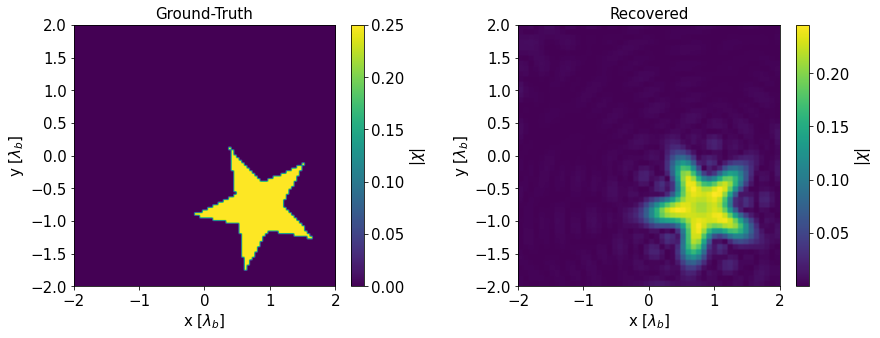

In [8]:
result.plot_map(show=True, fontsize=15, groundtruth=inputdata)

Let's have a look now at the convergence of each indicator:

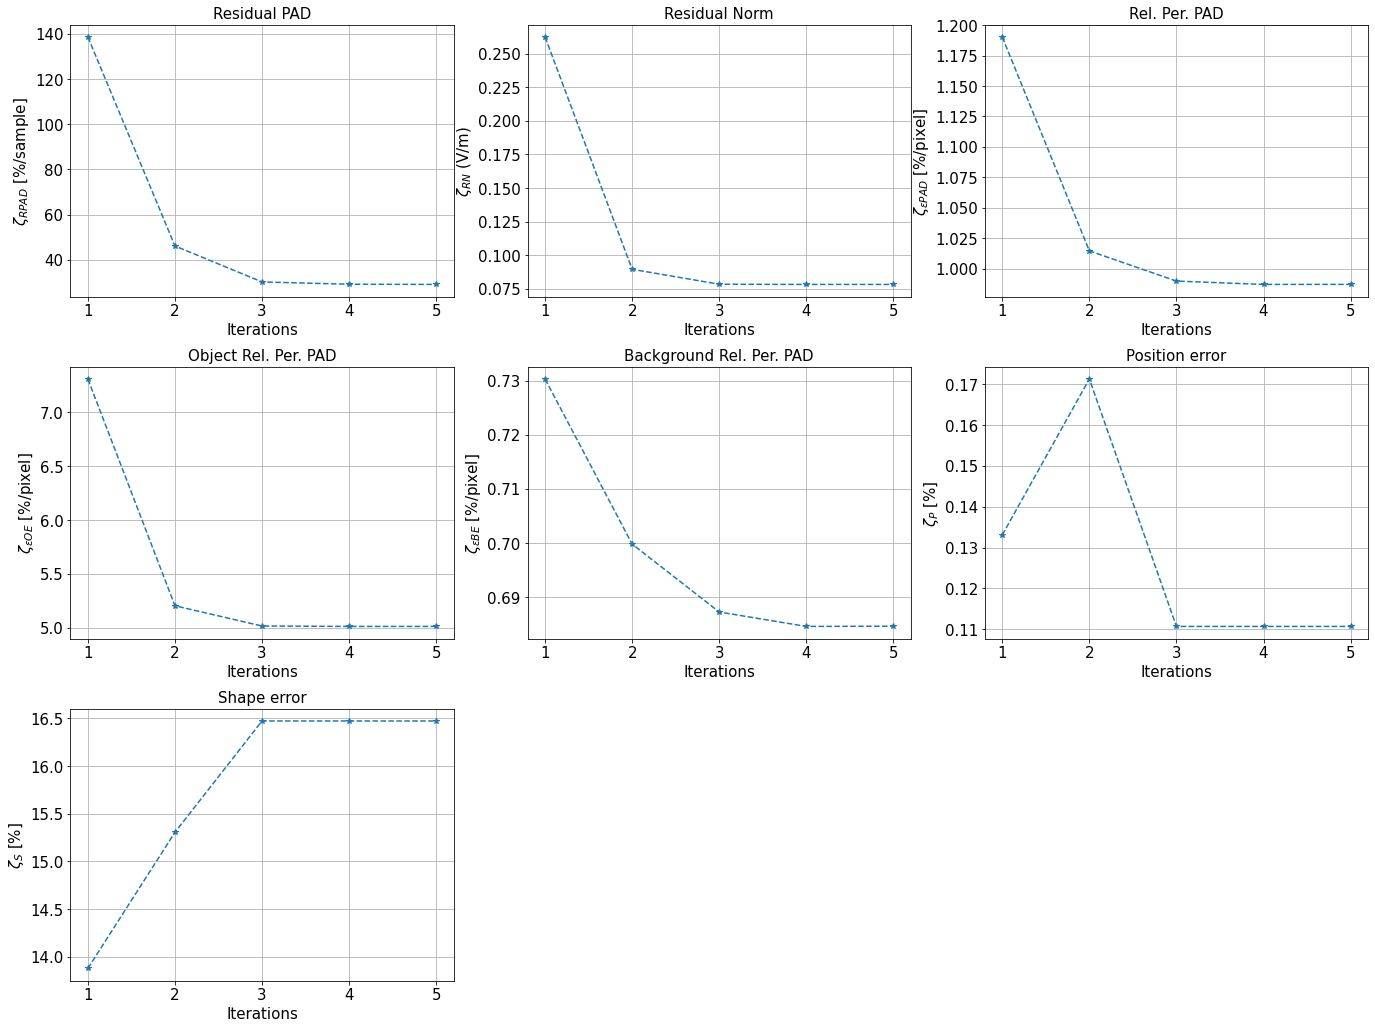

In [9]:
_ = result.plot_convergence(indicators=inputdata.indicators[:-1], fontsize=15,
                            show=True)

The execution time was:

In [10]:
print('Execution time: %.4f s' % result.execution_time)

Execution time: 25.6830 s


This concludes the manual definition usage example!